In [1]:
from dpks.quant_matrix import QuantMatrix
import pandas as pd
import seaborn as sns
from sklearn.cluster import DBSCAN, OPTICS, cluster_optics_dbscan, KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

In [3]:
def get_proteins_triv_name(proteins):
    human_proteome = pd.read_csv('../data/human_proteome.gz')
    human_proteome['accession'] = human_proteome['accession'].apply(lambda x: x.split('_')[0])
    names = []
    for protein in proteins:
        if protein in human_proteome['accession'].values:
            m = human_proteome.loc[human_proteome['accession'] == protein]['trivname'].values
            assert len(m) == 1
            m = m[0].split('_')[0]
        else:
            m = protein
        names.append(m)
    return names

def impute_uni(X, impute_percentile=0.1):
    X = np.nan_to_num(X)
    no_zero = X[X != 0]
    minvalue = no_zero.min()
    maxvalue = no_zero.max()*impute_percentile+minvalue
    mask = X == 0
    c = np.count_nonzero(mask)
    nums = np.random.uniform(minvalue, maxvalue, c)
    X[mask] = nums
    return X


In [93]:
#dataset = "sepsis"
scale = False
dataset = "sepsis"
if dataset == "covid":
    df = pd.read_csv("../data/ms/covid/AaronQM.tsv", sep="\t")
    design = pd.read_csv("../data/ms/covid/design_cropped.tsv", sep="\t")
    sample_col = "sample"
    samples1 = design[design['group'] == 1][sample_col].values.tolist()
    samples2 = design[design['group'] == 2][sample_col].values.tolist()
    top_proteins = ['FIBA', 'GELS', 'CO3', 'ZA2G','APOE','S10A8','VTNC','FIBB', 'FA9','F13A']
    top_proteins_impute=['FIBA','FIBB','S10A8','FA9','TSP1','APOE','PLF4','APOA1','CO3','RNAS1']
    top_proteins_DE = ['CRP','PIGR','SAA2','SAA1',  'CXCL7','LBP','PEDF','CYTC','ITIH4','ZA2G']
    top_proteins_DE_impute = ['SAA2',
                                'PLF4',
                                'S10A8',
                                'CXCL7',
                                'TSP1',
                                'PIGR',
                                'CRP',
                                'PEDF',
                                'LBP',
                                'ZA2G']

elif dataset == "sepsis":
    df = pd.read_csv("../data/ms/sepsis/QuantMatrix.csv")
    sample_col = "sample"
    design = pd.read_csv("../data/ms/sepsis/inner_design_matrix.tsv", sep="\t")
    samples1 = design[design['group'] == 1][sample_col].values.tolist()
    samples2 = design[design['group'] == 2][sample_col].values.tolist()
    top_proteins = ['ACTB', 'H2A1B',  'APOA1','APOB', 'CALR', 'OSTP','THRB', 'CD14',  'PSA3', 'H2B1A']
    top_proteins_impute = ['APOB','APOA1','CATZ','CALR', 'CD14','CO1A1','HBB','ACTB', 'APOA4', 'H2A1B']
    top_proteins_DE = ['CD14','DEF1','CD44','B2MG','PEDF','ICAM1','C163A','CYTC','B4GT1','C1RL']
    scaled_top_proteins_DE = ['DEF1','ICAM1','CD14','B2MG','CD44','PYGL','C163A','FCG3A','PEDF','LYAM1']
    
    
    
top_proteins = top_proteins_DE
df['Protein'] = get_proteins_triv_name(df['Protein'])
top_df = df[df['Protein'].isin(top_proteins)]
top_df.set_index('Protein', inplace=True)
top_df = top_df.loc[top_proteins]
top_df = top_df[samples1+samples2].T
X = top_df.fillna(0).to_numpy()
#X= impute_uni(X)
if scale:
    X = StandardScaler().fit_transform(X)
top_df.columns


Index(['CD14', 'DEF1', 'CD44', 'B2MG', 'PEDF', 'ICAM1', 'C163A', 'CYTC',
       'B4GT1', 'C1RL'],
      dtype='object', name='Protein')

True     130
False     67
Name: same, dtype: int64

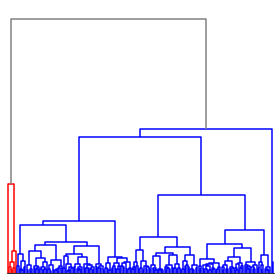

In [94]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster import hierarchy


plt.figure(figsize=(4,4))
linkage_data = linkage(X, method='ward', metric='euclidean', optimal_ordering=True)
hierarchy.set_link_color_palette(['r','b'])
d = dendrogram(linkage_data, above_threshold_color='gray')

plt.xticks([])
plt.yticks([])
sns.despine(left=True, top=True, bottom=False, right=True)

plt.tight_layout()
plt.savefig(f'../plots/manuscript/DE_Dendogram_{dataset}.jpg', dpi=300, bbox_inches='tight')

d_zip = pd.DataFrame({'index':d['leaves'], 'color':d['leaves_color_list'], sample_col:samples1+samples2})
#design = design.reset_index()
d_zip = d_zip.merge(design, how='left', on=sample_col)
d_zip['class'] = d_zip['color'].map({'r':1,'b':2})
d_zip['same'] = d_zip['class'] == d_zip['group']
d_zip['same_color'] = d_zip.apply(lambda x: 
    x['color'] if x['same'] == True else 'g', axis=1)
d_zip['same'].value_counts()

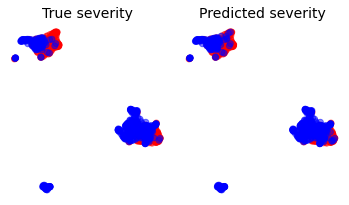

In [79]:
import umap


reducer = umap.UMAP()
embedding = reducer.fit_transform(X)

fig,ax = plt.subplots(1,2,figsize=(5,3))
ax[0].scatter(
    x=embedding[:, 0],
    y=embedding[:, 1],
    c = [c for c in d_zip['group'].map({1:'red',2:'blue'})],
    alpha=0.5,
    )
ax[0].set_title('True severity', fontsize=14)

ax[1].scatter(
    x=embedding[:, 0],
    y=embedding[:, 1],
    c = [c for c in d_zip['class'].map({1:'red',2:'blue'})],
    alpha=0.5,
    )
ax[1].set_title('Predicted severity', fontsize=14)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
plt.tight_layout()
sns.despine(left=True, top=True, bottom=True, right=True)
plt.savefig(f'../plots/manuscript/{dataset}_UMAP.jpg', dpi=300, bbox_inches='tight')


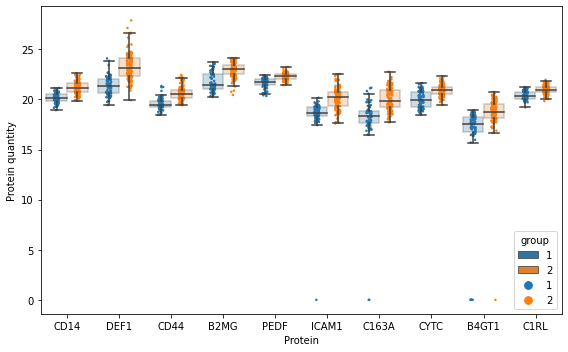

In [95]:
show_n = 10
X_N = X[:,0:show_n]
df_X = pd.DataFrame(X_N)
df_X.columns = top_proteins[0:show_n]
df_X['label'] = d_zip['group']
df_X['label'] = df_X['label'].map({1:'Group 1', 2:'Group 2'})

#g = sns.pairplot(df_X, hue="label", diag_kind='kde',height=1.5, palette=['red','blue'])

#g.set(xticklabels=[], yticklabels=[])
#plt.savefig('../plots/clustering/Correlation.jpg', dpi=300, bbox_inches='tight')


group_1 = df_X[df_X['label'] == "Group 1"]
group_1 = group_1[top_proteins]
group_2 = df_X[df_X['label'] == "Group 2"]
group_2 = group_2[top_proteins]
group_1 = pd.DataFrame(group_1.unstack()).reset_index()
group_1['group'] = 1

group_1.rename(columns={'level_0':'Protein',"0":'quant'}, inplace=True)

group_2 = pd.DataFrame(group_2.unstack()).reset_index()
group_2['group'] = 2
group_2.rename(columns={'level_0':'Protein',"0":'quant'}, inplace=True)

new_df = pd.concat([group_1,group_2])
new_df = new_df[['Protein',0,'group']]


#sns.boxplot(data=new_df, x="Protein", y=0, hue='group')
figure = plt.figure(figsize=(8,5))
sns.boxplot(data=new_df, x="Protein", y=0, hue='group', boxprops=dict(alpha=.25), fliersize=False)
sns.stripplot(data=new_df, x="Protein",y=0, hue='group', size=2.5, zorder=.5, dodge=True)
#plt.legend( frameon=False)
plt.ylabel('Protein quantity')
plt.xlabel('Protein')
plt.tight_layout()
plt.savefig(f'../plots/manuscript/DE_{dataset}_proteinBoxplot.jpg', dpi=300)